### Baseline Model

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import pandas as pd
import os
import dtale
import numpy as np

Load in dataset

In [47]:
project_dir = os.path.dirname(os.path.abspath(''))
df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
dtale.show(df).open_browser()

Assign dataset to X matrix and y vector and apply any necessary transformations.

In [99]:
X = df.loc[:, df.columns != 'Outcome']
X['Match_Relevance'] = 1 / (X['Match_Relevance'] ** 2)
y = df['Outcome']

In [88]:
X.tail()

,Season,Capacity,Elo_home,Elo_away,Day,Home_Team_Streak,Away_Team_Streak,Home_Team_Home_Streak,Away_Team_Away_Streak,Home_Team_Form,Away_Team_Form,Home_Team_Home_Form,Away_Team_Away_Form,Home_Team_Goals,Away_Team_Goals,Home_Team_Home_Goals,Away_Team_Away_Goals,Match_Relevance
105459,2021,41841,90,91,6,0,1,2,0,4,2,1,2,1.1,2.2,1.9,1.8,0.000007
105460,2021,62062,89,73,6,0,0,1,1,-3,0,0,-1,1.2,0.9,1.6,0.5,0.000007
105461,2021,32500,84,89,6,2,0,1,0,2,-2,2,1,1.6,1.6,1.5,1.1,0.000007
105462,2021,18482,60,72,6,3,0,2,1,1,-1,-1,-1,1.2,0.8,0.8,1.2,0.000007
105463,2021,21628,70,74,6,0,3,0,1,0,2,2,-1,1.1,1.6,1.1,1.4,0.000007


Split into training set and test set.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(X))

83509
14738
98247


Scale X by standardising it. Use the mean and standard deviation of the training set to standardise the test set.

In [101]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### Option 1) Logistic Regression

Train model.

In [102]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

LogisticRegression()

Test the accuracy of the model by checking against the test set. This consists of calculating the MSE and accuracy of the predicted classification.

In [103]:
y_pred_log = lgr.predict(X_test)
mse_log = mean_squared_error(y_test, y_pred_log)
y_delta_log = y_pred_log - y_test
accu_log = accuracy_score(y_test, y_pred_log) * 100
print(f'Logistic Regression Model\nAccuracy: {accu_log:.2f}%.\nMSE: {mse_log:.2f}')

Logistic Regression Model
Accuracy: 49.83%.
MSE: 1.16


#### Option 2) Linear Regression

Train model.

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Test the accuracy of the model by checking against the test set. This consists of calculating the MSE and accuracy of the predicted outcome.

In [67]:
y_pred_lin = np.rint(lr.predict(X_test))
mse_lin = mean_squared_error(y_test, y_pred_lin)
y_delta_lin = y_pred_lin - y_test
accu_lin = accuracy_score(y_test, y_pred_lin) * 100
print(f'Linear Regression Model\nAccuracy: {accu_lin:.2f}%.\nMSE: {mse_lin:.2f}')

Linear Regression Model
Accuracy: 34.48%.
MSE: 0.69


#### Conclusion
Baseline model is simple logistic regression with 49.75% accuracy.

Look at feature heatmap to understand correlations better.

<AxesSubplot:>

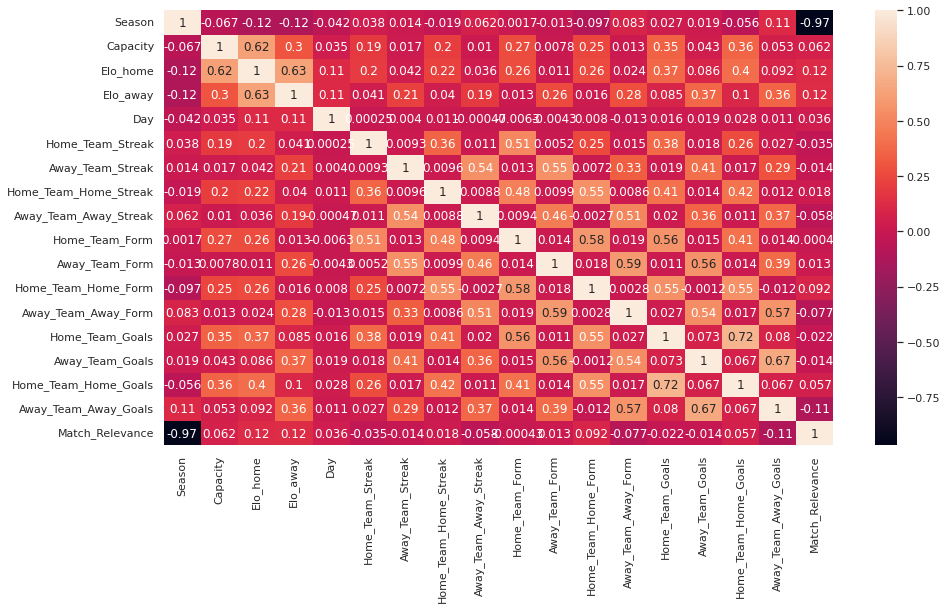

In [68]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr(), annot=True)